##Introdução
Este notebook contém a resolução da Atividade 2.2, abrangendo Regressão Linear, Testes de Hipótese, Intervalos de Confiança e Métodos Numéricos (Fatoração LU, Gauss-Jacobi e Gauss-Seidel), baseados nos materiais de Ruggiero & Lopes e slides fornecidos.

###A - Correlação

Objetivo: Gerar dois gráficos de dispersão (Scatter Plots).

* O primeiro deve mostrar uma correlação linear clara (Gene Y vs Gene X) com 9 pontos.

* O segundo deve ter dados gerados aleatoriamente (distribuição uniforme) no mesmo intervalo.

* Calcular a regressão linear, o p-value e a covariância para ambos, interpretando os resultados.

* Interpretação da função linregress: A função scipy.stats.linregress calcula uma regressão linear de mínimos quadrados para dois conjuntos de medições. Ela retorna a inclinação (slope), intercepto, coeficiente de correlação (r-value), p-value e erro padrão.

* P-value: Testa a hipótese nula de que a inclinação é zero (sem correlação). Um p-value baixo (ex: < 0.05) indica que existe uma correlação estatisticamente significativa.

* Covariância: Indica a direção da relação linear entre as variáveis. Positiva indica que movem juntas; negativa, inversamente.

--- Figura 1: Com Correlação ---
Equation: y = 1.98x + 0.78
R-squared: 0.9658
P-value: 0.0000
Covariance: 18.7646
------------------------------


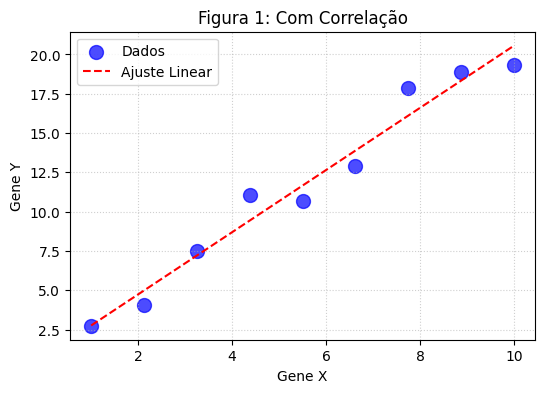

--- Figura 2: Dados Aleatórios ---
Equation: y = -1.55x + 15.77
R-squared: 0.3265
P-value: 0.1080
Covariance: -3.3207
------------------------------


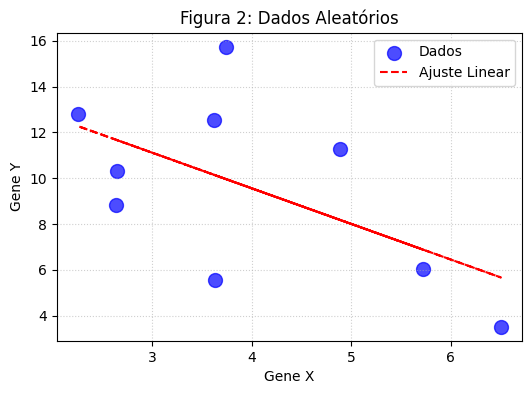

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Configuração para reprodutibilidade
np.random.seed(42)

# --- Caso 1: Correlação Linear ---
# Gerar dados com tendência linear
x1 = np.linspace(1, 10, 9)
# y = 2x + ruído leve
y1 = 2 * x1 + np.random.normal(0, 1.5, 9)

# --- Caso 2: Aleatório ---
# Distribuição uniforme no mesmo intervalo de x1 e y1
x2 = np.random.uniform(min(x1), max(x1), 9)
y2 = np.random.uniform(min(y1), max(y1), 9)

# Função para analisar e plotar
def analisar_dados(x, y, titulo):
    # Regressão Linear e P-value
    res = stats.linregress(x, y)

    # Covariância
    covaria = np.cov(x, y)[0, 1]

    print(f"--- {titulo} ---")
    print(f"Equação: y = {res.slope:.2f}x + {res.intercept:.2f}")
    print(f"R-squared: {res.rvalue**2:.4f}")
    print(f"P-value: {res.pvalue:.4f}")
    print(f"Covariancia: {covaria:.4f}")
    print("-" * 30)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, color='blue', s=100, alpha=0.7, label='Dados')
    plt.plot(x, res.intercept + res.slope * x, 'r--', label='Ajuste Linear')
    plt.title(titulo)
    plt.xlabel('Gene X')
    plt.ylabel('Gene Y')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

# Executar análises
analisar_dados(x1, y1, "Figura 1: Com Correlação")
analisar_dados(x2, y2, "Figura 2: Dados Aleatórios")

###B: Estimando um Intervalo de Confiança para a Média

Objetivo: Calcular e visualizar o intervalo de confiança (IC) para a média de uma população.

* Um IC de 95% significa que, se repetíssemos a amostragem muitas vezes, 95% dos intervalos calculados conteriam a média real da população.

* Usaremos a distribuição t-Student, pois geralmente o desvio padrão da população é desconhecido.

Média da Amostra: 81.73
IC 90%: (np.float64(78.22556172806343), np.float64(85.24110493860324))
IC 95%: (np.float64(77.46184151004572), np.float64(86.00482515662095))
IC 99%: (np.float64(75.8047440378506), np.float64(87.66192262881607))


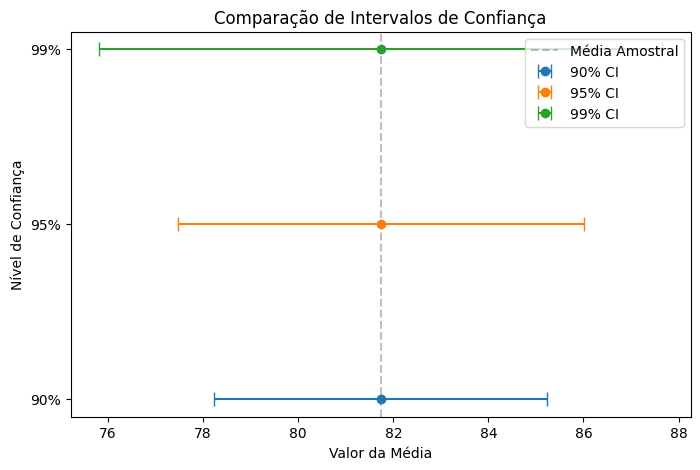

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# 1. Conjunto de dados amostrais (ex: notas de testes)
dados = np.array([78, 85, 92, 68, 88, 75, 82, 90, 84, 79, 70, 95, 81, 76, 83])

# 2. Calcular estatísticas
media_amostral = np.mean(dados)
erro_padrao = stats.sem(dados) # (s / sqrt(n))
n = len(dados)
graus_liberdade = n - 1

# Níveis de confiança para o desafio
niveis_confianca = [0.90, 0.95, 0.99]
intervalos = []

print(f"Média da Amostra: {media_amostral:.2f}")

for conf in niveis_confianca:
    # Calcular intervalo usando scipy.stats
    intervalo = stats.t.interval(confidence=conf, df=graus_liberdade, loc=media_amostral, scale=erro_padrao)
    intervalos.append((conf, intervalo))
    print(f"IC {conf*100:.0f}%: {intervalo}")

# 3. Visualização
plt.figure(figsize=(8, 5))
y_pos = range(len(niveis_confianca))
for i, (conf, (inf, sup)) in enumerate(intervalos):
    centro = (inf + sup) / 2
    erro = sup - centro
    plt.errorbar(centro, i, xerr=erro, fmt='o', capsize=5, label=f'{conf*100:.0f}% CI')

plt.yticks(y_pos, [f'{c*100:.0f}%' for c in niveis_confianca])
plt.xlabel('Valor da Média')
plt.ylabel('Nível de Confiança')
plt.title('Comparação de Intervalos de Confiança')
plt.axvline(media_amostral, color='gray', linestyle='--', alpha=0.5, label='Média Amostral')
plt.legend()
plt.show()

###C: P-value em um Teste de Hipótese

Cenário: Comparação entre Grupo de Controle e Grupo de Teste.

* Hipótese Nula ($H_0$): As médias dos dois grupos são iguais (não há diferença significativa).

* Teste: T-test de duas amostras independentes (ttest_ind).

* Decisão: Se $p\text{-value} < 0.05$, rejeitamos $H_0$.

In [ ]:
from scipy import stats
import numpy as np

# 1. Dados simulados
# Grupo controle: média ~50
grupo_controle = np.random.normal(50, 10, 30)
# Grupo teste: média ~58 (simulando um efeito)
grupo_teste = np.random.normal(58, 10, 30)

# 2. Teste T
t_stat, p_val = stats.ttest_ind(grupo_controle, grupo_teste)

# 3. Interpretação
alpha = 0.05
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < alpha:
    print("Resultado: Rejeitamos a hipótese nula. Há diferença significativa entre os grupos.")
else:
    print("Resultado: Falhamos em rejeitar a hipótese nula. Não há evidência suficiente de diferença.")

T-statistic: -4.0457
P-value: 0.0002
Resultado: Rejeitamos a hipótese nula. Há diferença significativa entre os grupos.


###D: Significance Level (Simulação de Erro Tipo I)

Slide: [Nível de Significância e Erro Tipo I.pdf](https://drive.google.com/file/d/16MvHJehe1tB_URJUpamc-anTJ4Z-pkfM/view?usp=sharing)


Código Python: Testes para criação do slide

In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# Configuração para garantir que os resultados sejam reproduzíveis
np.random.seed(42)

def executar_simulacao_erro_tipo_1(nivel_significancia):
    """
    Executa uma simulação de Monte Carlo para demonstrar o Erro Tipo I.
    """
    # 1. Definição dos Parâmetros
    num_simulacoes = 10000   # Quantidade de testes A/B simulados
    tamanho_amostra = 30     # Tamanho de cada grupo (n=30)

    # Parâmetros da População Real (Idênticos para ambos os grupos)
    media_real = 50
    desvio_padrao_real = 10

    # Contador de "Falsos Positivos"
    resultados_significativos = 0

    print(f"--- Iniciando Simulação com Alpha = {nivel_significancia} ---")

    # 2. Loop de Simulação
    for _ in range(num_simulacoes):
        # Gerar dois grupos vindos EXATAMENTE da mesma população (H0 é verdadeira)
        grupo1 = np.random.normal(media_real, desvio_padrao_real, tamanho_amostra)
        grupo2 = np.random.normal(media_real, desvio_padrao_real, tamanho_amostra)

        # 3. Executar o Teste-T
        # ttest_ind retorna a estatística T e o p-value
        t_stat, p_value = ttest_ind(grupo1, grupo2)

        # 4. Verificação: Rejeitamos a hipótese nula?
        if p_value < nivel_significancia:
            resultados_significativos += 1

    # 5. Cálculo da Proporção (Taxa de Erro Tipo I)
    proporcao = resultados_significativos / num_simulacoes

    print(f"Total de testes realizados: {num_simulacoes}")
    print(f"Testes significativos (Falsos Positivos): {resultados_significativos}")
    print(f"Proporção Observada: {proporcao:.4f} ({proporcao*100:.2f}%)")
    print(f"Proporção Esperada (Alpha): {nivel_significancia}")
    print("-" * 40 + "\n")

# --- Execução dos Cenários para os Slides ---

# Cenário 1: Padrão (Alpha = 0.05)
# Esperamos errar em ~5% dos casos
executar_simulacao_erro_tipo_1(0.05)

# Cenário 2: Mais Rigoroso (Alpha = 0.01)
# Esperamos errar em ~1% dos casos
executar_simulacao_erro_tipo_1(0.01)

--- Iniciando Simulação com Alpha = 0.05 ---
Total de testes realizados: 10000
Testes significativos (Falsos Positivos): 508
Proporção Observada: 0.0508 (5.08%)
Proporção Esperada (Alpha): 0.05
----------------------------------------

--- Iniciando Simulação com Alpha = 0.01 ---
Total de testes realizados: 10000
Testes significativos (Falsos Positivos): 116
Proporção Observada: 0.0116 (1.16%)
Proporção Esperada (Alpha): 0.01
----------------------------------------



###E: Reproduzindo Slides em Código

Objetivo: Reproduzir o cálculo do Intervalo de Confiança conforme os slides 24 a 46 do slide "What are confidence intervals" dado pelo professor.

* Os slides mostram uma amostra de tamanho $n=50$.

* Média amostral ($\bar{x}$) = 75.9 BPM.

* Nível de confiança = 95%.

* Os slides calculam o valor crítico $t$ e a margem de erro.

In [ ]:
import scipy.stats as stats
import math

# Dados extraídos dos slides (Parâmetros do cenário)
n = 50                 # Tamanho da amostra
media_amostral = 75.9  # Média mostrada nos slides
confianca = 0.95       # Nível de confiança
alpha = 1 - confianca
graus_liberdade = n - 1

# O slide mostra uma margem de erro de 3.8 (79.7 - 75.9 = 3.8)
# E também mostra "Standard Error" ou calculo similar.
# Vamos calcular o t-critical como no slide
t_critical = stats.t.ppf(1 - alpha/2, graus_liberdade)

print(f"--- Reprodução dos Slides 24-46 ---")
print(f"Tamanho da amostra (n): {n}")
print(f"Graus de liberdade: {graus_liberdade}")
print(f"Nível de Confiança: {confianca*100}%")
print(f"Valor Crítico t (slide 296): {t_critical:.4f}") # Deve ser aprox 2.0096

# Reconstruindo o desvio padrão da amostra baseado no intervalo final do slide
# Slide 14 mostra intervalo [72.1, 79.7]
# Margem de erro (ME) = 79.7 - 75.9 = 3.8
me_slide = 3.8
# Formula: ME = t * (s / sqrt(n)) -> s = (ME * sqrt(n)) / t
s_reconstruido = (me_slide * math.sqrt(n)) / t_critical

print(f"Desvio Padrão estimado (s): {s_reconstruido:.2f}")

# Cálculo final do intervalo
limite_inferior = media_amostral - me_slide
limite_superior = media_amostral + me_slide

print(f"\nIntervalo de Confiança Calculado:")
print(f"Média: {media_amostral}")
print(f"Margem de Erro: +/- {me_slide}")
print(f"Intervalo: [{limite_inferior:.1f}, {limite_superior:.1f}]")
print("Interpretação (Slide 23): Estamos 95% confiantes de que a média real está entre 72.1 e 79.7.")

--- Reprodução dos Slides 24-46 ---
Tamanho da amostra (n): 50
Graus de liberdade: 49
Nível de Confiança: 95.0%
Valor Crítico t (slide 296): 2.0096
Desvio Padrão estimado (s): 13.37

Intervalo de Confiança Calculado:
Média: 75.9
Margem de Erro: +/- 3.8
Intervalo: [72.1, 79.7]
Interpretação (Slide 23): Estamos 95% confiantes de que a média real está entre 72.1 e 79.7.


###F: Regressão Linear Manual e Rotações

Objetivo:

1. Ajustar uma reta aos dados "Mouse size" vs "Mouse weight".

2. Comparar com scikit-learn e statsmodels.

3. Demonstrar como a rotação da reta (alterando o coeficiente angular 'a') afeta a Soma dos Resíduos Quadráticos (SSR).

Melhor Slope (Scikit): 0.7860
Intercepto: 0.1511
R2 (Scikit): 0.9697

--- Estatísticas Statsmodels ---
R-squared: 0.9697
F-statistic: 416.5842
Prob (F-statistic): 2.9391e-11
P-value (x1): 2.9391e-11


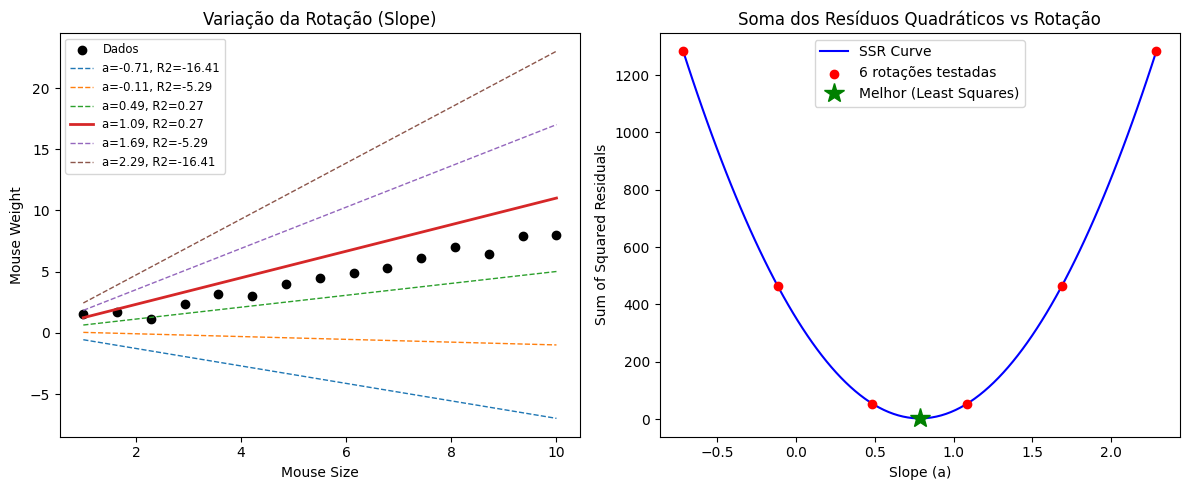


--- Comparação de R-Squared ---
Melhor R2 (Scikit): 0.9697
Slope -0.71: R2 = -16.4100
Slope -0.11: R2 = -5.2870
Slope 0.49: R2 = 0.2745
Slope 1.09: R2 = 0.2745
Slope 1.69: R2 = -5.2870
Slope 2.29: R2 = -16.4100


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# 1. Gerar dados simulados baseados na equação do slide y = 0.1 + 0.78x
np.random.seed(10)
x_mouse = np.linspace(1, 10, 15).reshape(-1, 1) # Mouse size
# Adicionando ruído para simular dados reais
y_mouse = 0.1 + 0.78 * x_mouse.flatten() + np.random.normal(0, 0.5, 15) # Mouse weight

# 2. Scikit-learn Linear Regression
model = LinearRegression()
model.fit(x_mouse, y_mouse)
best_slope = model.coef_[0]
best_intercept = model.intercept_
r2_sklearn = model.score(x_mouse, y_mouse)

print(f"Melhor Slope (Scikit): {best_slope:.4f}")
print(f"Intercepto: {best_intercept:.4f}")
print(f"R2 (Scikit): {r2_sklearn:.4f}")

# 3. Statsmodels para estatísticas detalhadas
X_sm = sm.add_constant(x_mouse)
model_sm = sm.OLS(y_mouse, X_sm).fit()
print("\n--- Estatísticas Statsmodels ---")
print(f"R-squared: {model_sm.rsquared:.4f}")
print(f"F-statistic: {model_sm.fvalue:.4f}")
print(f"Prob (F-statistic): {model_sm.f_pvalue:.4e}")
print(f"P-value (x1): {model_sm.pvalues[1]:.4e}")

# 4. Rotações e Gráfico de Resíduos
# Usaremos o intercepto fixo (best_intercept) e variaremos o slope (a)
slopes_teste = np.linspace(best_slope - 1.5, best_slope + 1.5, 6) # 6 diferentes 'a's
ssr_values = []
r2_values = []

plt.figure(figsize=(12, 5))

# Subplot 1: As Retas
plt.subplot(1, 2, 1)
plt.scatter(x_mouse, y_mouse, color='black', label='Dados')

for slope in slopes_teste:
    y_pred = best_intercept + slope * x_mouse.flatten()
    # Calcular Soma dos Resíduos Quadráticos (SSR)
    ssr = np.sum((y_mouse - y_pred)**2)
    ssr_values.append(ssr)

    # Calcular R2 manualmente para cada rotação
    ss_total = np.sum((y_mouse - np.mean(y_mouse))**2)
    r2 = 1 - (ssr / ss_total)
    r2_values.append(r2)

    style = '-' if slope == slopes_teste[3] else '--'
    width = 2 if slope == slopes_teste[3] else 1
    plt.plot(x_mouse, y_pred, linestyle=style, linewidth=width, label=f'a={slope:.2f}, R2={r2:.2f}')

plt.title("Variação da Rotação (Slope)")
plt.xlabel("Mouse Size")
plt.ylabel("Mouse Weight")
plt.legend(fontsize='small')

# Subplot 2: Gráfico da Parábola (SSR vs Rotação)
plt.subplot(1, 2, 2)
# Vamos gerar mais pontos para ficar uma curva suave
slopes_smooth = np.linspace(best_slope - 1.5, best_slope + 1.5, 100)
ssr_smooth = []
for s in slopes_smooth:
    pred = best_intercept + s * x_mouse.flatten()
    ssr_smooth.append(np.sum((y_mouse - pred)**2))

plt.plot(slopes_smooth, ssr_smooth, 'b-', label='SSR Curve')
plt.scatter(slopes_teste, ssr_values, c='red', zorder=5, label='6 rotações testadas')
plt.plot(best_slope, np.min(ssr_smooth), 'g*', markersize=15, label='Melhor (Least Squares)')

plt.title("Soma dos Resíduos Quadráticos vs Rotação")
plt.xlabel("Slope (a)")
plt.ylabel("Sum of Squared Residuals")
plt.legend()

plt.tight_layout()
plt.show()

# Comparação de R2
print("\n--- Comparação de R-Squared ---")
print(f"Melhor R2 (Scikit): {r2_sklearn:.4f}")
for s, r2 in zip(slopes_teste, r2_values):
    print(f"Slope {s:.2f}: R2 = {r2:.4f}")

###G: Fatoração LU com Pivoteamento Parcial

Algoritmo: Implementação baseada no pseudocódigo das páginas 146-147 do livro de Ruggiero & Lopes .
Como o "Exemplo 7:
Sistema Linear:$$3x_1 - 4x_2 + x_3 = 9$$$$x_1 + 2x_2 + 2x_3 = 3$$$$4x_1 - 3x_3 = -2$$

* Matriz A: [[3, -4, 1], [1, 2, 2], [4, 0, -3]]

* Vetor b: [9, 3, -2]

* Solução Esperada (do livro): $x = [1, -1, 2]^T$

* Fatores L e U esperados:

  * L = [[1, 0, 0], [3/2, 1, 0], [1/4, -1/2, 1]]
  * U = [[4, 0, -3], [0, -4, 13/4], [0, 0, 35/8]]

In [ ]:
import numpy as np

def lu_factorization_pivot_step_by_step(A_in, b_in):
    # Trabalhar com float para evitar erros de arredondamento
    A = A_in.astype(float).copy()
    b = b_in.astype(float).copy()
    n = len(b)

    # Vetor de permutação P (inicialmente identidade)
    p = np.arange(n)

    print(f"--- Exemplo 7: Fatoração LU com Pivoteamento ---")
    print(f"Matriz Inicial A(0):\n{A}")
    print(f"Vetor b: {b}\n")

    # Eliminação Gaussiana com Pivoteamento
    for k in range(n - 1):
        print(f"--- Etapa {k+1} ---")

        # 1. Escolha do Pivô (Pivoteamento Parcial)
        # Busca o maior valor absoluto na coluna k, das linhas k até n
        max_val = 0
        r = k
        for i in range(k, n):
            if abs(A[i, k]) > max_val:
                max_val = abs(A[i, k])
                r = i

        print(f"Pivô escolhido: {A[r, k]} (estava na linha {r}, vai para {k})")

        # 2. Permutações (se necessário)
        if r != k:
            # Troca no vetor de permutação
            p[[k, r]] = p[[r, k]]
            # Troca na matriz A (linhas inteiras)
            A[[k, r], :] = A[[r, k], :]
            print(f"Permutando linhas {k} e {r}...")
            print(f"Matriz após permutação:\n{A}")

        # Checagem de singularidade
        if A[k, k] == 0:
            print("Matriz Singular! Pivô zero.")
            return None

        # 3. Eliminação (Cálculo dos multiplicadores)
        print("Calculando multiplicadores e eliminando...")
        for i in range(k + 1, n):
            m = A[i, k] / A[k, k]
            A[i, k] = m # Armazena o multiplicador na parte inferior (L)
            for j in range(k + 1, n):
                A[i, j] = A[i, j] - m * A[k, j]

        print(f"Matriz A({k+1}) (L guardado na parte inferior):\n{A}\n")

    # Separação L e U para exibição final igual ao livro
    L = np.eye(n)
    U = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i > j:
                L[i, j] = A[i, j]
            else:
                U[i, j] = A[i, j]

    print("--- Resultado da Fatoração ---")
    print("Fator L:\n", L)
    print("Fator U:\n", U)
    print("Vetor de Permutação final p:", p)

    # Resolução dos Sistemas
    print("\n--- Resolução dos Sistemas ---")

    # 1. Resolver Ly = Pb
    # Aplicar a permutação final ao vetor b original
    b_perm = b[p]
    print(f"Vetor Pb (b permutado): {b_perm}")

    y = np.zeros(n)
    # Substituição progressiva (Forward Substitution)
    for i in range(n):
        soma = 0
        for j in range(i):
            soma += L[i, j] * y[j]
        y[i] = b_perm[i] - soma
    print(f"Solução de Ly = Pb -> y: {y}")

    # 2. Resolver Ux = y
    x = np.zeros(n)
    # Substituição regressiva (Backward Substitution)
    for i in range(n - 1, -1, -1):
        soma = 0
        for j in range(i + 1, n):
            soma += U[i, j] * x[j]
        x[i] = (y[i] - soma) / U[i, i]

    print(f"Solução Final x: {x}")
    return x

# Dados EXATOS do Exemplo 7 (Arquivo 155-158.pdf)
A_ex7 = np.array([[3., -4., 1.],
                  [1., 2., 2.],
                  [4., 0., -3.]])
b_ex7 = np.array([9., 3., -2.])

lu_factorization_pivot_step_by_step(A_ex7, b_ex7)

--- Exemplo 7: Fatoração LU com Pivoteamento ---
Matriz Inicial A(0):
[[ 3. -4.  1.]
 [ 1.  2.  2.]
 [ 4.  0. -3.]]
Vetor b: [ 9.  3. -2.]

--- Etapa 1 ---
Pivô escolhido: 4.0 (estava na linha 2, vai para 0)
Permutando linhas 0 e 2...
Matriz após permutação:
[[ 4.  0. -3.]
 [ 1.  2.  2.]
 [ 3. -4.  1.]]
Calculando multiplicadores e eliminando...
Matriz A(1) (L guardado na parte inferior):
[[ 4.    0.   -3.  ]
 [ 0.25  2.    2.75]
 [ 0.75 -4.    3.25]]

--- Etapa 2 ---
Pivô escolhido: -4.0 (estava na linha 2, vai para 1)
Permutando linhas 1 e 2...
Matriz após permutação:
[[ 4.    0.   -3.  ]
 [ 0.75 -4.    3.25]
 [ 0.25  2.    2.75]]
Calculando multiplicadores e eliminando...
Matriz A(2) (L guardado na parte inferior):
[[ 4.     0.    -3.   ]
 [ 0.75  -4.     3.25 ]
 [ 0.25  -0.5    4.375]]

--- Resultado da Fatoração ---
Fator L:
 [[ 1.    0.    0.  ]
 [ 0.75  1.    0.  ]
 [ 0.25 -0.5   1.  ]]
Fator U:
 [[ 4.     0.    -3.   ]
 [ 0.    -4.     3.25 ]
 [ 0.     0.     4.375]]
Vetor de P

array([ 1., -1.,  2.])

###H: Método Iterativo de Gauss-Jacobi

Algoritmo: Implementação do Teorema 4 (Critério das Linhas/Diagonal Dominante) e do Método iterativo.

Aplicação: Exemplo 10 (Página 157).
Sistema:
$$10x_1 + 2x_2 + x_3 = 7$$$$x_1 + 5x_2 + x_3 = -8$$$$2x_1 + 3x_2 + 10x_3 = 6$$Chute inicial $x^{(0)} = [0.7, -1.6, 0.6]$, Tolerância $\epsilon = 0.05$.

In [ ]:
import numpy as np

def gauss_jacobi(A, b, x0, tol, max_iter=100):
    n = len(b)
    x = x0.copy()
    x_new = np.zeros(n)

    # Teorema 4 (Critério das Linhas) [cite: 73]
    print("--- Verificação Teorema 4 (Critério das Linhas) ---")
    alphas = []
    for i in range(n):
        soma_linha = sum(abs(A[i, j]) for j in range(n) if j != i)
        alpha = soma_linha / abs(A[i, i])
        alphas.append(alpha)
        print(f"Linha {i+1}: alpha = {alpha:.2f}")

    max_alpha = max(alphas)
    if max_alpha < 1:
        print(f"Converge! (max alpha = {max_alpha:.2f} < 1)\n")
    else:
        print(f"Atenção: Critério das linhas não satisfeito (max alpha = {max_alpha:.2f})\n")

    print("--- Iterações (Passo a Passo) ---")
    print(f"k=0: {x}")

    for k in range(max_iter):
        for i in range(n):
            soma = 0
            for j in range(n):
                if i != j:
                    soma += A[i, j] * x[j]
            x_new[i] = (b[i] - soma) / A[i, i]

        # Cálculo do erro relativo (norma infinito)
        erro = np.max(np.abs(x_new - x)) / np.max(np.abs(x_new))

        print(f"k={k+1}: {x_new}, Erro={erro:.4f}")

        if erro < tol:
            print(f"\nConvergência alcançada em {k+1} iterações.")
            return x_new

        x = x_new.copy()

    return x

# Dados do Exemplo 10
A_jacobi = np.array([[10., 2., 1.],
                     [1., 5., 1.],
                     [2., 3., 10.]])
b_jacobi = np.array([7., -8., 6.])
x0_jacobi = np.array([0.7, -1.6, 0.6])
tol = 0.05

solucao = gauss_jacobi(A_jacobi, b_jacobi, x0_jacobi, tol)

--- Verificação Teorema 4 (Critério das Linhas) ---
Linha 1: alpha = 0.30
Linha 2: alpha = 0.40
Linha 3: alpha = 0.50
Converge! (max alpha = 0.50 < 1)

--- Iterações (Passo a Passo) ---
k=0: [ 0.7 -1.6  0.6]
k=1: [ 0.96 -1.86  0.94], Erro=0.1828
k=2: [ 0.978 -1.98   0.966], Erro=0.0606
k=3: [ 0.9994 -1.9888  0.9984], Erro=0.0163

Convergência alcançada em 3 iterações.


###I: Método Iterativo de Gauss-Seidel

Algoritmo: Implementação do Critério de Sassenfeld e do algoritmo Gauss-Seidel.

Aplicação: Exemplo 14 (Página 162).
Sistema:
$$5x_1 + x_2 + x_3 = 5$$$$3x_1 + 4x_2 + x_3 = 6$$$$3x_1 + 3x_2 + 6x_3 = 0$$Chute inicial $x^{(0)} = [0, 0, 0]$, Tolerância $\epsilon = 0.05$.

In [ ]:
import numpy as np

def sassenfeld_criterion(A):
    n = len(A)
    betas = np.zeros(n)
    print("--- Critério de Sassenfeld [cite: 652] ---")

    for i in range(n):
        soma = 0
        # Parte já atualizada (beta * a_ij)
        for j in range(i):
            soma += betas[j] * abs(A[i, j])
        # Parte ainda não atualizada (1 * a_ij)
        for j in range(i + 1, n):
            soma += abs(A[i, j])

        betas[i] = soma / abs(A[i, i])
        print(f"Beta_{i+1}: {betas[i]:.4f}")

    if max(betas) < 1:
        print(f"Converge! (max beta = {max(betas):.4f} < 1)\n")
    else:
        print("Critério de Sassenfeld não garante convergência.\n")

def gauss_seidel(A, b, x0, tol, max_iter=100):
    n = len(b)
    x = x0.copy()

    # Verificar Sassenfeld antes
    sassenfeld_criterion(A)

    print("--- Iterações Gauss-Seidel (Passo a Passo) ---")
    print(f"k=0: {x}")

    for k in range(max_iter):
        x_old = x.copy()

        for i in range(n):
            soma = 0
            # Usa valores JÁ atualizados (x[j]) se j < i
            # Usa valores antigos (x[j]) se j > i
            # No Python, como alteramos 'x' in-place, isso é automático
            for j in range(n):
                if i != j:
                    soma += A[i, j] * x[j]

            x[i] = (b[i] - soma) / A[i, i]

        # Erro relativo
        # Evitar divisão por zero
        norma_num = np.max(np.abs(x - x_old))
        norma_den = np.max(np.abs(x))
        if norma_den == 0: erro = 999
        else: erro = norma_num / norma_den

        print(f"k={k+1}: {x}, Erro={erro:.4f}")

        if erro < tol:
            print(f"\nConvergência alcançada em {k+1} iterações.")
            return x

    return x

# Dados do Exemplo 14
A_seidel = np.array([[5., 1., 1.],
                     [3., 4., 1.],
                     [3., 3., 6.]])
b_seidel = np.array([5., 6., 0.])
x0_seidel = np.array([0., 0., 0.])
tol_seidel = 5e-2 # 0.05

solucao_gs = gauss_seidel(A_seidel, b_seidel, x0_seidel, tol_seidel)

--- Critério de Sassenfeld [cite: 652] ---
Beta_1: 0.4000
Beta_2: 0.5500
Beta_3: 0.4750
Converge! (max beta = 0.5500 < 1)

--- Iterações Gauss-Seidel (Passo a Passo) ---
k=0: [0. 0. 0.]
k=1: [ 1.     0.75  -0.875], Erro=1.0000
k=2: [ 1.025   0.95   -0.9875], Erro=0.1951
k=3: [ 1.0075    0.99125  -0.999375], Erro=0.0409

Convergência alcançada em 3 iterações.
